# We are taking the features that we came up with in the PCA analysis and apply them to the 3 SL models (Logistic Regression, Random Forest, and SVM) to see how well they perform.


In [38]:
#standard data manip
import pandas as pd
import numpy as np

#sklearn supervised learning libs
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

#visualizing
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_csv('/content/drive/MyDrive/Milestone2data/sl_seqn_demo.csv')


#features that we derived from PCA analysis
selected_features = [
    "Seen mental health professional/past yr",
    "Difficulty these problems have caused",
    "Difficulty with self-care",
    #"PHQ9_TOTAL", This is out dependent var
    "Routine place to go for healthcare",
    "Past 12 months had video conf w/Dr?",
    "Education level - Adults 20+",
    "Sleep hours - weekdays or workdays",
    "Monthly poverty index",
    "Type place most often go for healthcare",
    "Age in years at screening",
    "Covered by health insurance",
    "How often feel worried/nervous/anxious",
    "Sleep hours - weekends",
    "Total number of people in the Household",
    "Gender",
    "Level of feeling worried/nervous/anxious",
    "Time when no insurance in past year?",
    "Covered by private insurance",
    "Covered by Medicare"
]

df

,SEQN,SDDSRVYR,RIDSTATR,Gender,Age in years at screening,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,Covered by state-sponsored health plan,Time when no insurance in past year?,Routine place to go for healthcare,Type place most often go for healthcare,Past 12 months had video conf w/Dr?,Seen mental health professional/past yr,Monthly poverty index,Sleep hours - weekdays or workdays,Sleep hours - weekends,PHQ9_TOTAL
0,130391.0,12.0,2.0,1,33,NaN,3.0,3.0,2.0,NaN,...,0,0,1,1,0,0,0.94,7.5,7.5,24.0
1,130397.0,12.0,2.0,1,67,NaN,3.0,3.0,1.0,NaN,...,0,0,1,1,0,0,3.28,8.0,8.0,8.0
2,130426.0,12.0,2.0,0,67,NaN,1.0,1.0,1.0,NaN,...,0,0,1,1,0,0,NaN,6.0,6.0,11.0
3,130457.0,12.0,2.0,1,38,NaN,3.0,3.0,1.0,NaN,...,0,0,1,1,1,1,5.00,8.5,13.5,14.0
4,130596.0,12.0,2.0,1,66,NaN,2.0,2.0,1.0,NaN,...,0,0,0,0,0,0,NaN,6.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,142232.0,12.0,2.0,1,62,NaN,3.0,3.0,1.0,NaN,...,0,0,1,1,0,1,1.09,7.5,7.5,12.0
463,142233.0,12.0,2.0,0,19,NaN,3.0,3.0,1.0,233.0,...,0,0,0,0,1,0,NaN,8.5,6.5,16.0
464,142241.0,12.0,2.0,0,51,NaN,3.0,3.0,2.0,NaN,...,0,0,1,1,0,0,4.80,7.5,8.5,8.0
465,142252.0,12.0,2.0,0,61,NaN,3.0,3.0,1.0,NaN,...,0,1,0,0,0,0,5.00,5.0,5.0,22.0


There exists missing values in some of the columns (cleaned the majority of the columns), but it can be taken care of during model runtime.

In [40]:
df.isnull().sum()

,0
SEQN,0
SDDSRVYR,0
RIDSTATR,0
Gender,0
Age in years at screening,0
RIDAGEMN,467
RIDRETH1,0
RIDRETH3,0
RIDEXMON,0
RIDEXAGM,442


#Estimating Income from Census Reference
A new feature, Median_Income, is created to enrich the dataset’s socioeconomic context. This variable is not reported directly in NHANES but is estimated using U.S. Census data based on each participant’s demographic profile.

Each respondent is assigned a typical income value using the following attributes:

- Race
- Education level
- Gender

#This estimation method is adapted from Brandon Fox’s demographic-matching strategy:

- NHANES demographic codes are mapped to grouped census categories
- Median income is assigned using an exact match from the reference file
- If no match is found, the overall median income across all groups is used as a fallback


The resulting feature serves as a proxy for household income, offering a consistent and interpretable measure of socioeconomic status without relying on self-reported financial data.

In [41]:
# Load census-based income reference
income_reference = pd.read_csv("/content/drive/MyDrive/Milestone2data/income_reference.csv")

# Load demographic inputs used for matching
demo = pd.read_csv("/content/drive/MyDrive/Milestone2data/sl_seqn_demo.csv")

# Keep relevant columns and rename them
demo_filtered = demo[["SEQN", "RIDRETH3", "Education level - Adults 20+", "Gender"]].dropna()
demo_filtered = demo_filtered.rename(columns={
    "RIDRETH3": "Race",
    "Education level - Adults 20+": "Education"
})

# Map numeric codes to readable groupings
race_map = {
    1: "White",
    2: "Hispanic (any race)",
    3: "White, not Hispanic",
    4: "Black",
    6: "Asian",
    7: "Other"
}
edu_map = {
    1: "No high school diploma",
    2: "No high school diploma",
    3: "High school, no college",
    4: "Some college",
    5: "Bachelor's degree or higher"
}
gender_map = {1: "Male", 2: "Female"}

demo_filtered["Race_Group"] = demo_filtered["Race"].map(race_map)
demo_filtered["Edu_Group"] = demo_filtered["Education"].map(edu_map)
demo_filtered["Gender_Label"] = demo_filtered["Gender"].map(gender_map)

# Merge demographic groups with income reference
demo_income = demo_filtered.merge(
    income_reference,
    on=["Race_Group", "Edu_Group", "Gender_Label"],
    how="left"
)

# Fill in any unmatched groups with the overall mean
mean_income = income_reference["Median_Income"].mean()
demo_income["Median_Income"] = demo_income["Median_Income"].fillna(mean_income)

# Merge income estimates back into modeling dataset
df = df.merge(demo_income[["SEQN", "Median_Income"]], on="SEQN", how="left")

# Add to predictor list if not already there
if "Median_Income" not in selected_features:
    selected_features.append("Median_Income")

# Optional: Check final distribution
df["Median_Income"].describe()

,Median_Income
count,467.000000
mean,86946.355460
std,17076.292024
min,36230.000000
25%,85448.000000
50%,85448.000000
75%,85448.000000
max,126800.000000


Before we create the models we have to make the data look nice for classification models. This involves binning the PHQ-9 variable so that the model has less classes to learn.

In [42]:
# Bin PHQ-9 scores into standard severity categories for classification
bins = [-1, 4, 9, 14, 19, 27]
labels = ["None/Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]
df["target_cls"] = pd.cut(df["PHQ9_TOTAL"], bins=bins, labels=labels)

Now that the df is more classification friendly we can split the data for the model.

In [43]:
X = df[selected_features]

#use the binned target (cls) for cls problems
y_cls = df["target_cls"]

#stratify here to have equal class balance in both sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

imputer = SimpleImputer(strategy='median')
X_train_cls = pd.DataFrame(imputer.fit_transform(X_train_cls), columns=X_train_cls.columns)
X_test_cls = pd.DataFrame(imputer.transform(X_test_cls), columns=X_test_cls.columns)


# now to dive into Grid Search to find the best hyper parameters for **Logistic Regression**.

In [44]:

logPipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# Set stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid
hpgrid = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10, 100],  # smaller C = stronger regularization
    "logreg__penalty": ["l2"],                   # standard penalty for stability
    "logreg__solver": ["lbfgs"],                 # supports multiclass with l2
    "logreg__class_weight": [None, "balanced"]   # adjust for imbalanced classes
}

# GridSearchCV
grid = GridSearchCV(
    estimator=logPipe,
    param_grid=hpgrid,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

# Fit grid search on training data only
grid.fit(X_train_cls, y_train_cls)

# Best parameters
print("Best Logistic Regression Params:", grid.best_params_)

Best Logistic Regression Params: {'logreg__C': 10, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}



Now that we have the best hyper parameters lets train and test the Logistic Model


                   precision    recall  f1-score   support

             Mild       0.39      0.43      0.41        30
         Moderate       0.48      0.53      0.50        38
Moderately Severe       0.36      0.28      0.31        18
           Severe       0.40      0.25      0.31         8

         accuracy                           0.43        94
        macro avg       0.41      0.37      0.38        94
     weighted avg       0.42      0.43      0.42        94



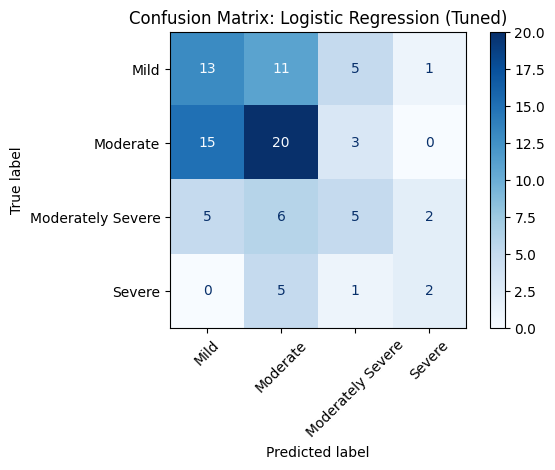

Test ROC-AUC (OvR, macro): 0.658


In [45]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

y_pred = grid.best_estimator_.predict(X_test_cls)
y_proba = grid.best_estimator_.predict_proba(X_test_cls)

#this will show us precision, recall, f1-score, and support scores for the Logicstic Regression Model
print(classification_report(y_test_cls, y_pred))

best_logreg_model = grid.best_estimator_
cm_logreg = confusion_matrix(y_test_cls, y_pred, labels=best_logreg_model.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=best_logreg_model.classes_)
disp_logreg.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Logistic Regression (Tuned)")
plt.tight_layout()
plt.show()

# ROC-AUC score (macro average)
auc_logreg = roc_auc_score(y_test_cls, y_proba, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_logreg:.3f}")


accuracy: 0.44

f1: 0.40

ROC-AUC (macro): 0.663

From all the numbers above we see that the model does a decent job predicting mild and moderate labels for the dataset and it gets significantly worse in severe and moderately severe.

We also got a Roc Auc score of 0.663 which is low and shows that the model can be improved.

# Now we are going to do find the best hyper parameters for  **Random Forest**

In [46]:

RFPipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

# Use the Stratified K Fold from before

# Hyperparameter grid
hpgrid = {
    "rf__n_estimators": [100, 300, 500],               # number of trees in the forest
    "rf__max_depth": [None, 10, 20, 40],               # limits how deep trees can grow
    "rf__min_samples_split": [2, 5, 10],               # min samples needed to split a node
    "rf__min_samples_leaf": [1, 2, 4],                 # min samples in a leaf to prevent overfitting
    "rf__bootstrap": [True],                           # use sampling with replacement (default)
    "rf__class_weight": [None, "balanced_subsample"]   # balance class weights during training
}

# GridSearchCV
grid = GridSearchCV(
    estimator=RFPipe,
    param_grid=hpgrid,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

# Fit grid search on training data only
grid.fit(X_train_cls, y_train_cls)

# Best parameters
print("Best Random Forest Params:", grid.best_params_)

Best Random Forest Params: {'rf__bootstrap': True, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


Now we have the best hyper parameters lets test and score the model.



Classification Report:
                    precision    recall  f1-score   support

             Mild       0.29      0.37      0.32        30
         Moderate       0.38      0.37      0.37        38
Moderately Severe       0.27      0.17      0.21        18
           Severe       0.25      0.25      0.25         8

         accuracy                           0.32        94
        macro avg       0.30      0.29      0.29        94
     weighted avg       0.32      0.32      0.32        94



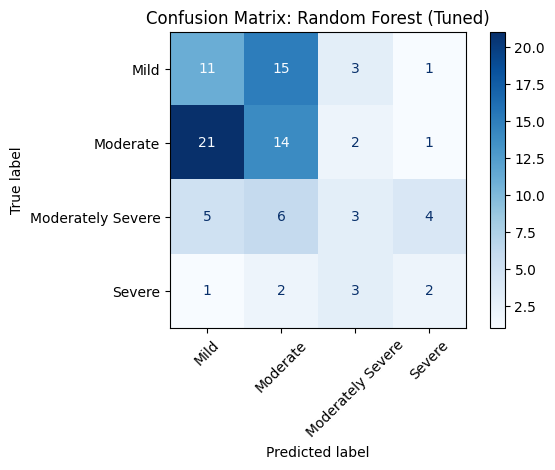

Test ROC-AUC (OvR, macro): 0.620


In [47]:
# Get predictions and probabilities
y_pred_rf = grid.best_estimator_.predict(X_test_cls)
y_proba_rf = grid.best_estimator_.predict_proba(X_test_cls)

# Classification report
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_rf))

# Confusion matrix
best_rf_model = grid.best_estimator_
cm_rf = confusion_matrix(y_test_cls, y_pred_rf, labels=best_rf_model.named_steps['rf'].classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_rf_model.named_steps['rf'].classes_)
disp_rf.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Random Forest (Tuned)")
plt.tight_layout()
plt.show()

# ROC-AUC score (macro average)
auc_rf = roc_auc_score(y_test_cls, y_proba_rf, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_rf:.3f}")

accuracy: 0.32

f1: 0.30

ROC-AUC (macro): 0.628

The model does a slightly worse job predicting the same mild and moderate classes from before and a worse job in general predicting the rest of the classes.

The ROC-AUC score is 0.628 which is slightly less than the Logistic Regression Model and low in general.

# Now we are going to do find the best hyper parameters for  **SVM**

In [48]:
# SVM pipeline
SVMPipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

# SVM hyperparameter grid
hpgrid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto'],  # Only applies to 'rbf' kernel
    'svm__class_weight': [None, 'balanced']
}

# Grid search
grid = GridSearchCV(
    estimator=SVMPipe,
    param_grid=hpgrid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit on training data
grid.fit(X_train_cls, y_train_cls)

# Show best parameters
print("Best SVM Parameters:", grid.best_params_)

Best SVM Parameters: {'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


Now that we have the hyper parameters for the model lets test and score the model.


Classification Report:
                    precision    recall  f1-score   support

             Mild       0.32      0.40      0.36        30
         Moderate       0.45      0.24      0.31        38
Moderately Severe       0.22      0.28      0.24        18
           Severe       0.21      0.38      0.27         8

         accuracy                           0.31        94
        macro avg       0.30      0.32      0.30        94
     weighted avg       0.35      0.31      0.31        94



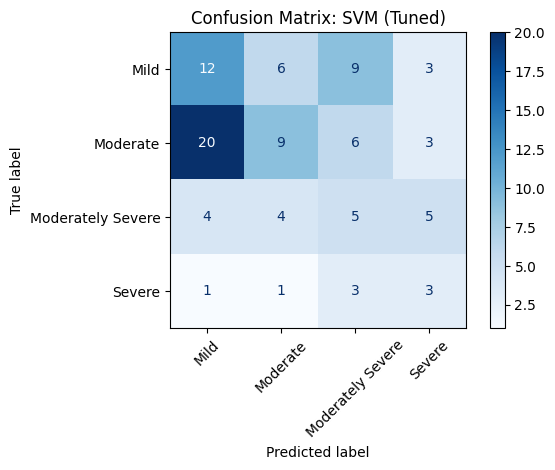

Test ROC-AUC (OvR, macro): 0.629


In [49]:
y_pred_svm = grid.best_estimator_.predict(X_test_cls)
y_proba_svm = grid.best_estimator_.predict_proba(X_test_cls)

# Classification report
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_svm))

# Confusion matrix
best_svm_model = grid.best_estimator_
cm_svm = confusion_matrix(y_test_cls, y_pred_svm, labels=best_svm_model.named_steps['svm'].classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=best_svm_model.named_steps['svm'].classes_)
disp_svm.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: SVM (Tuned)")
plt.tight_layout()
plt.show()

# ROC-AUC (macro, OvR)
auc_svm = roc_auc_score(y_test_cls, y_proba_svm, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_svm:.3f}")

accuracy: 0.40

f1: 0.36

ROC-AUC (macro): 0.661

The model does a has the near same performance as the Logistic Regression Model

The ROC-AUC score is 0.661 which is slightly less than the Logistic Regression Model and low in general.

# Now lets look at how all the models performed and what model we should look at moving forward.

In [50]:
import pandas as pd

# data from the models
data = {
    "Model": ["Logistic Regression", "SVM", "Random Forest"],
    "Accuracy": [0.44, 0.32, 0.40],
    "F1 Score": [0.40, 0.30, 0.36],
    "ROC-AUC (Macro)": [0.663, 0.628, 0.661]
}

# to DF type
results_df = pd.DataFrame(data)

print(results_df)

                 Model  Accuracy  F1 Score  ROC-AUC (Macro)
0  Logistic Regression      0.44      0.40            0.663
1                  SVM      0.32      0.30            0.628
2        Random Forest      0.40      0.36            0.661


After compiling the scores we see that Logistic Regression is the best performing model when looking at each of the scores.

Lets take a closer look at Logistic Regression.

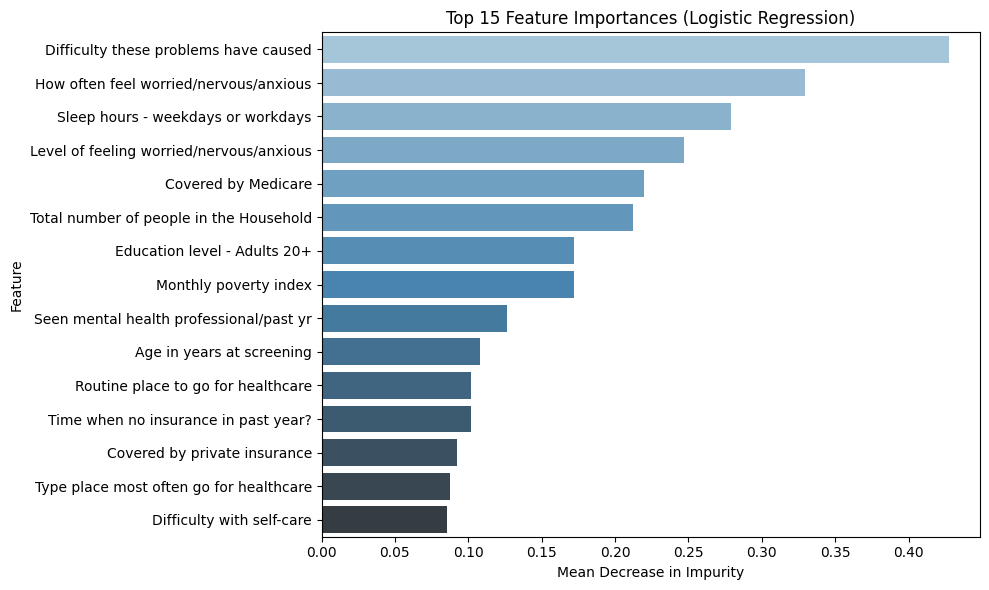

In [51]:
# I want to get the most important features now from Log Reg Model
coefs = best_logreg_model.named_steps["logreg"].coef_
mean_importance = np.mean(np.abs(coefs), axis=0)

feat_df = pd.DataFrame({
    "Feature": X_train_cls.columns,
    "Importance": mean_importance
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x="Importance", y="Feature", palette="Blues_d")
plt.title("Top 15 Feature Importances (Logistic Regression)")
plt.xlabel("Mean Decrease in Impurity")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Now we are going to look at how the model would function if we only has **socioeconomic columns** in it. We want to see how well the socioeconomic columns predict depression.

In [53]:
selected_features_socio = [
    #"PHQ9_TOTAL", This is out dependent var
    "Median_Income",
    "Routine place to go for healthcare",
    "Past 12 months had video conf w/Dr?",
    "Education level - Adults 20+",
    "Monthly poverty index",
    "Type place most often go for healthcare",
    "Age in years at screening",
    "Covered by health insurance",
    "Total number of people in the Household",
    "Gender",
    "Time when no insurance in past year?",
    "Covered by private insurance",
    "Covered by Medicare"
]


sociodf = df[selected_features_socio]

X = df[selected_features_socio]

y_cls_sc = df["target_cls"]

#stratify here to have equal class balance in both sets
X_train_cls_sc, X_test_cls_sc, y_train_cls_sc, y_test_cls_sc = train_test_split(
    X, y_cls_sc, test_size=0.2, random_state=42, stratify=y_cls_sc
)

imputer = SimpleImputer(strategy='median')
X_train_cls_sc = pd.DataFrame(imputer.fit_transform(X_train_cls_sc), columns=X_train_cls_sc.columns)
X_test_cls_sc = pd.DataFrame(imputer.transform(X_test_cls_sc), columns=X_test_cls_sc.columns)

Now lets run the same Logistic Regression Model we ran before but with the features above.

                   precision    recall  f1-score   support

             Mild       0.26      0.20      0.23        30
         Moderate       0.40      0.61      0.48        38
Moderately Severe       0.23      0.17      0.19        18
           Severe       0.00      0.00      0.00         8

         accuracy                           0.34        94
        macro avg       0.22      0.24      0.22        94
     weighted avg       0.29      0.34      0.30        94



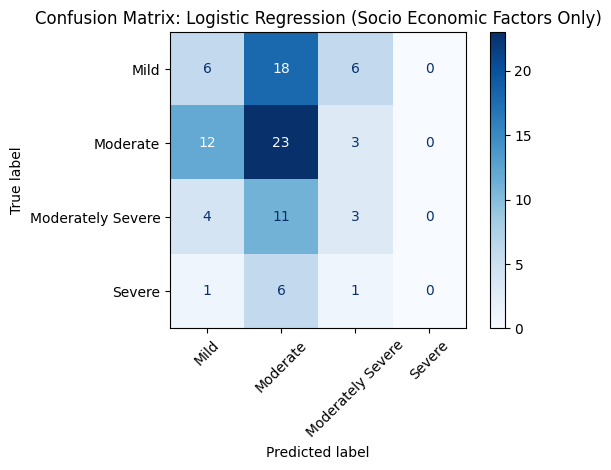

Test ROC-AUC (OvR, macro): 0.658


In [54]:
logregPipe_sc = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        C=1,
        class_weight=None,
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])

# Fit on pre-imputed training data
logregPipe_sc.fit(X_train_cls_sc, y_train_cls_sc)

# Predict and evaluate on test set
y_pred_sc = logregPipe_sc.predict(X_test_cls_sc)
y_proba_sc = logregPipe_sc.predict_proba(X_test_cls_sc)

#this will show us precision, recall, f1-score, and support scores for the Logicstic Regression Model
print(classification_report(y_test_cls_sc, y_pred_sc))

best_logreg_model = grid.best_estimator_
cm_logreg = confusion_matrix(y_test_cls_sc, y_pred_sc, labels=best_logreg_model.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=best_logreg_model.classes_)
disp_logreg.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Logistic Regression (Socio Economic Factors Only)")
plt.tight_layout()
plt.show()

# ROC-AUC score (macro average)
auc_logreg = roc_auc_score(y_test_cls, y_proba, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_logreg:.3f}")

inital model ->  socioeconomic factor modeling

accuracy: 0.44 -> 0.36

f1: 0.40 -> 0.24

ROC-AUC (macro): 0.663 -> 0.663

We can see that only having the socioeconomic factors reduces the accuracy by .08 and reduces the f1 score considerably. ROC-AUC score is unaffected in this case. This model exhibits the same behavour of being able to predict mild and moderate with a much higher degree than moderately severe and severe.

In [55]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save best estimators
joblib.dump(best_logreg_model, "models/best_logreg_vikram.pkl")
joblib.dump(best_rf_model, "models/best_rf_vikram.pkl")
joblib.dump(best_svm_model, "models/best_svm_vikram.pkl")

['models/best_svm_vikram.pkl']